### This is a notebook to format your data for segmentation, run the images through the cloud instance of DeepCell, and then extract marker counts and morphological information from all the cells in your images

In [ ]:
# import required packages
import os
import warnings

from ark.utils import data_utils, load_utils, io_utils, deepcell_service_utils, segmentation_utils
from ark.segmentation import marker_quantification

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

In [ ]:
# set up file paths
base_dir = "../data/example_dataset"
input_dir = os.path.join(base_dir, "input_data")
tiff_dir = os.path.join(input_dir, "single_channel_inputs/")
deepcell_input_dir = os.path.join(input_dir, "deepcell_input/")
deepcell_output_dir = os.path.join(base_dir, 'deepcell_output')
single_cell_dir = os.path.join(base_dir, "single_cell_output")
label_dir = os.path.join(base_dir, 'deepcell_output')
viz_dir = os.path.join(base_dir, "deepcell_visualization")

# create directories if do not exist
for directory in [deepcell_input_dir, deepcell_output_dir, single_cell_dir, viz_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

### Here we are using the example data located in /data/example_dataset/input_data. To modify this notebook to run using your own data, simply change the base_dir to point to your own sub-directory within the data folder, rather than 'example_dataset'. 

In [ ]:
# set this to true for multi-channel tiffs
MIBItiff = False

# data file suffix for low-level processed data
# only needed for MIBItiff = True
MIBItiff_suffix = "-MassCorrected-Filtered.tiff"

# nuclear channel name(s) (or nucs = None)
nucs = ['HH3']

# membrane channel name(s) (or mems = None)
mems = ['Membrane']

# validate paths
io_utils.validate_paths([base_dir,
                         input_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         single_cell_dir
                         ])

### compute and filter fov paths

In [ ]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov1", "fov2"]

# TODO: MIBItiff manual selection

### load images into notebook, process, and save as deepcell compatable input

In [ ]:
# load channels to be included in deepcell data
channels = (nucs if nucs else []) + (mems if mems else [])

# filter channels for None (just in case)
channels = [channel for channel in channels if channel is not None]

if MIBItiff:
    data_xr = load_utils.load_imgs_from_mibitiff(tiff_dir, mibitiff_files=fovs, channels=channels)
else:
    data_xr = load_utils.load_imgs_from_tree(tiff_dir, img_sub_folder="TIFs", fovs=fovs, channels=channels)

# generate and save deepcell input tifs
data_utils.generate_deepcell_input(data_xr, deepcell_input_dir, nucs, mems)

## Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [ ]:
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs)

### We can then load the segmented mask from deepcell via label-map TIFFs and save as an xarray

In [ ]:
segmentation_labels = load_utils.load_imgs_from_dir(data_dir=label_dir,
                                                    xr_dim_name='compartments',
                                                    xr_channel_names=['whole_cell'],
                                                    delimiter='_feature_0',
                                                    force_ints=True)


save_name = os.path.join(label_dir, 'segmentation_labels.xr')
if os.path.exists(save_name):
    print("overwriting previously generated processed output file")
    os.remove(save_name)

segmentation_labels.to_netcdf(save_name, format="NETCDF3_64BIT")

### We can also then save the segmented mask overlaid on the imaging data

In [ ]:
data_xr_summed = load_utils.load_imgs_from_dir(data_dir=deepcell_input_dir,
                                               files=[fov + '.tif' for fov in data_xr.coords['fovs'].values],
                                               xr_dim_name='compartments',
                                               xr_channel_names=['nuclear_channel', 'membrane_channel'])

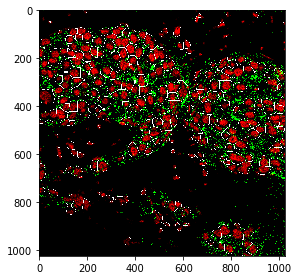

In [11]:
# Both channels and Point8

# Overlaying the DNA
overlay_channels = data_xr.channels.values
warnings.simplefilter("ignore")

# Channel 0 and Point 8
segmentation_utils.visualize_segmentation(
    segmentation_labels_xr=segmentation_labels,
    fovs=data_xr[:,:,:,0].fovs.values, channel_data_xr=data_xr,
    chan_list=overlay_channels, output_dir=viz_dir, show=True)

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [ ]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_labels=segmentation_labels,
                                             tiff_dir=tiff_dir,
                                             img_sub_folder="TIFs",
                                             is_mibitiff=MIBItiff,
                                             fovs=fovs,
                                             batch_size=5)


In [ ]:
# save extracted data as csv for downstream analysis
cell_table_size_normalized.to_csv(os.path.join(single_cell_dir, 'cell_table_size_normalized.csv'),
                                 index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(single_cell_dir, 'cell_table_arcsinh_transformed.csv'),
                                     index=False)

In [ ]:
# save extracted data as csv for downstream analysis
cell_table_size_normalized.to_csv(os.path.join(single_cell_dir, 'cell_table_size_normalized.csv'),
                                 index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(single_cell_dir, 'cell_table_arcsinh_transformed.csv'),
                                     index=False)